# Hierarchical Window Clustering Approach to detecting Spiking Motifs 

### Sparse method

## Data Generation

In [256]:
'''
Model parameters
'''
import random
import numpy as np

M = 1 # Number of Spiking motifs
N = 60 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 2000
dt = 1
nrn_fr = 5 # hz
pg_fr = 4 # hz
background_noise_fr = 10 # h


np.random.seed(0)

In [257]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [258]:
params = {'M': 4, 'N': 60, 'D': 30, 'T': 1000, 'nrn_fr': 10, 'pg_fr': 4, 'background_noise_fr': 1}
M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params.values()

In [259]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.rand(N,D,M)*1000
nrn_frs = np.zeros((M))
for m in range(M):
    nrn_frs[m] = np.random.poisson(nrn_fr)
    K_dense[:,:,m] = (K_dense[:,:,m] < nrn_frs[m]).astype('int')
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)


# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.rand(M,T)*1000
pg_frs = np.zeros((M))
for m in range(M):
    pg_frs[m] = np.random.poisson(pg_fr)
    B_dense[m,:] = (B_dense[m,:] < pg_frs[m]).astype('int')
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.rand(N,T+D)*1000
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]

A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1

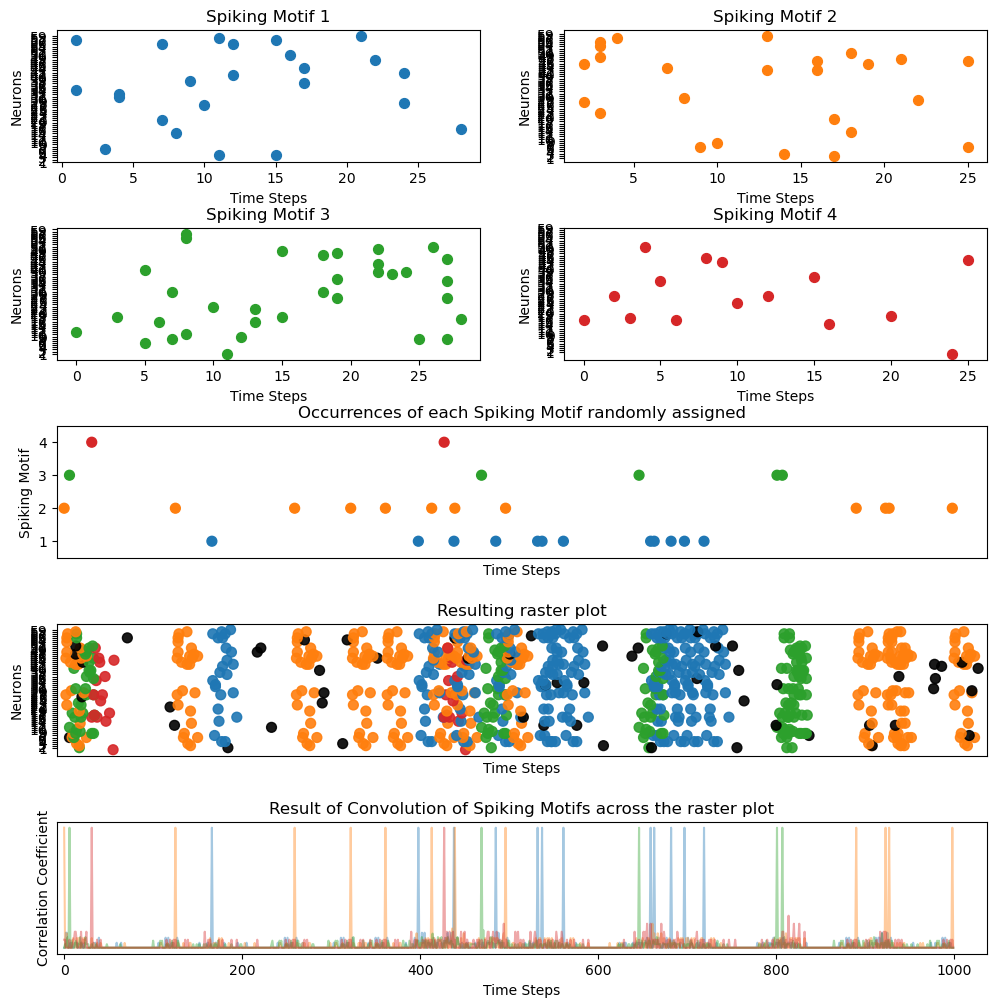

In [260]:
import matplotlib.ticker as ticker

fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

s = 50

# Scatter plots for A, B, C, D
for i, k in enumerate(['A', 'B', 'C', 'D']):
    ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
    ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
    ax[k].set_xlabel('Time Steps')
    ax[k].set_ylabel('Neurons')
    ax[k].set_yticks(range(1, N))

spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
ax['E'].set_xlabel('Time Steps')
ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

# Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


# Scatter plot for F
ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.9, s=s*4, marker='.')
ax['F'].set_title('Resulting raster plot')
ax['F'].set_xlabel('Time Steps')
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

sanity_check = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        sanity_check[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

# Plot for G
[ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

# Set common x-axis from 0 to 1000 with padding
common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
padding = 10
ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

# Share x-axis for E, F, and G
ax['E'].sharex(ax['F'])
ax['G'].sharex(ax['F'])

# Hide x-axis ticks and labels for E and F
ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


In [261]:
sum([A_sparse[0].tolist().count(n) for n in np.unique(A_sparse[0])])

843

This is the generated dataset that we will be working with. The lower panel shows the convolution of the the "Spiking Motifs" with the full raster plot. This convolution shows that by knowing the shape of the spiking motifs, the patterns can be robustly detected.

In [157]:
A_dense = None

## Clustering 1 sparse

In [262]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Windowing the data
window_dim = int(np.ceil(D/2)) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
N_labels = A_sparse[0].copy()
T_labels = A_sparse[1].copy()

T_labels = np.round(T_labels).astype(int)
T_labels, N_labels = np.unique(np.array([T_labels,N_labels]),axis=1) # This removes any spikes that occur at the same neuron at the same time
N=max(N_labels)+1

windows = np.zeros((len(T_labels)),dtype='object')
for i,window_time in enumerate(T_labels):
    condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
    window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
    window =  {tuple(row) for row in  window}
    windows[i] = window

HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = np.zeros_like(T_labels)
for n in range(N):
    idc = np.where(N_labels==n)[0]
    windows_n = windows[idc]
    if len(windows_n) > 1:
        x = np.zeros((len(windows_n),len(windows_n)))
        for i in range(windows_n.shape[0]):
            for j in range(windows_n.shape[0]):
                common_rows = windows_n[i].intersection(windows_n[j])
                num_identical_rows = len(common_rows)
                x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
        np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
        sim_mats.append(x) 
        dissimilarity = 1 - x
        if not np.all(dissimilarity == 0):
            HDPs.append(linkage(dissimilarity, method='complete'))
            l = max(clusters)+1
            clusters[idc]= l+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance')

clusters= np.array(clusters)

In [263]:
K_sparse, print('num SM repetitions: ' + str(len(B_sparse[0])))

num SM repetitions: 31


((array([ 0,  1,  2,  3,  4,  4,  6,  6,  6,  7,  8,  8,  8,  8,  9, 10, 11,
         13, 14, 14, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 19, 20, 22, 22,
         23, 24, 27, 27, 27, 27, 27, 27, 28, 28, 29, 30, 30, 31, 32, 34, 34,
         35, 36, 36, 37, 38, 38, 39, 39, 40, 41, 42, 42, 42, 43, 43, 43, 44,
         44, 45, 45, 45, 45, 46, 46, 47, 47, 48, 48, 48, 49, 50, 50, 50, 50,
         51, 53, 55, 55, 55, 55, 57, 57, 57, 57, 58, 58, 59], dtype=int64),
  array([24, 11, 17, 14, 11, 15,  5,  9, 25,  3,  7, 10, 25, 27, 12,  8,  0,
         18,  8, 16,  0,  6,  6, 13, 28,  3, 28,  3, 15, 20, 17,  7,  3, 13,
         10, 10,  2,  2, 10, 12, 19, 27, 22, 24,  8,  7, 18,  4,  4,  1,  5,
         27, 15, 19, 17,  9, 23, 22, 24,  5, 12, 13, 16, 24,  7,  9, 22, 17,
         25,  2,  8, 19, 27, 16, 25, 18, 21,  3, 19, 22, 15,  4, 16, 18, 22,
         26,  3,  3,  7,  8, 12,  1,  4,  8, 15, 11, 13, 21], dtype=int64),
  array([4, 3, 2, 2, 1, 1, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 3, 2, 1, 4, 4, 3,
   

In [264]:
q = 7
x = sim_mats[q] - np.eye(sim_mats[q].shape[0])
y = sim_mats[q]

In [265]:
dissimx = x-1
dissimy= y-1

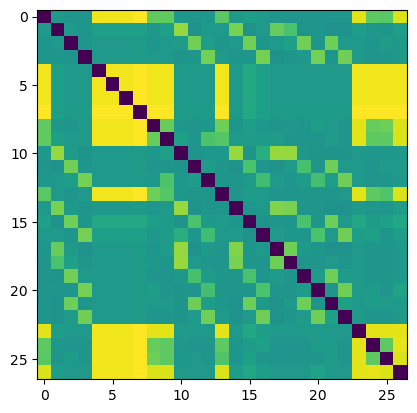

In [266]:
plt.figure()
plt.imshow(dissimx)

In [267]:
np.where(A_sparse[2][A_sparse[0]==q])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),)

In [268]:
print(np.mean([A_sparse[0].tolist().count(n) for n in np.unique(A_sparse[0])]))
[A_sparse[0].tolist().count(n) for n in np.unique(A_sparse[0])][q]

15.053571428571429


27

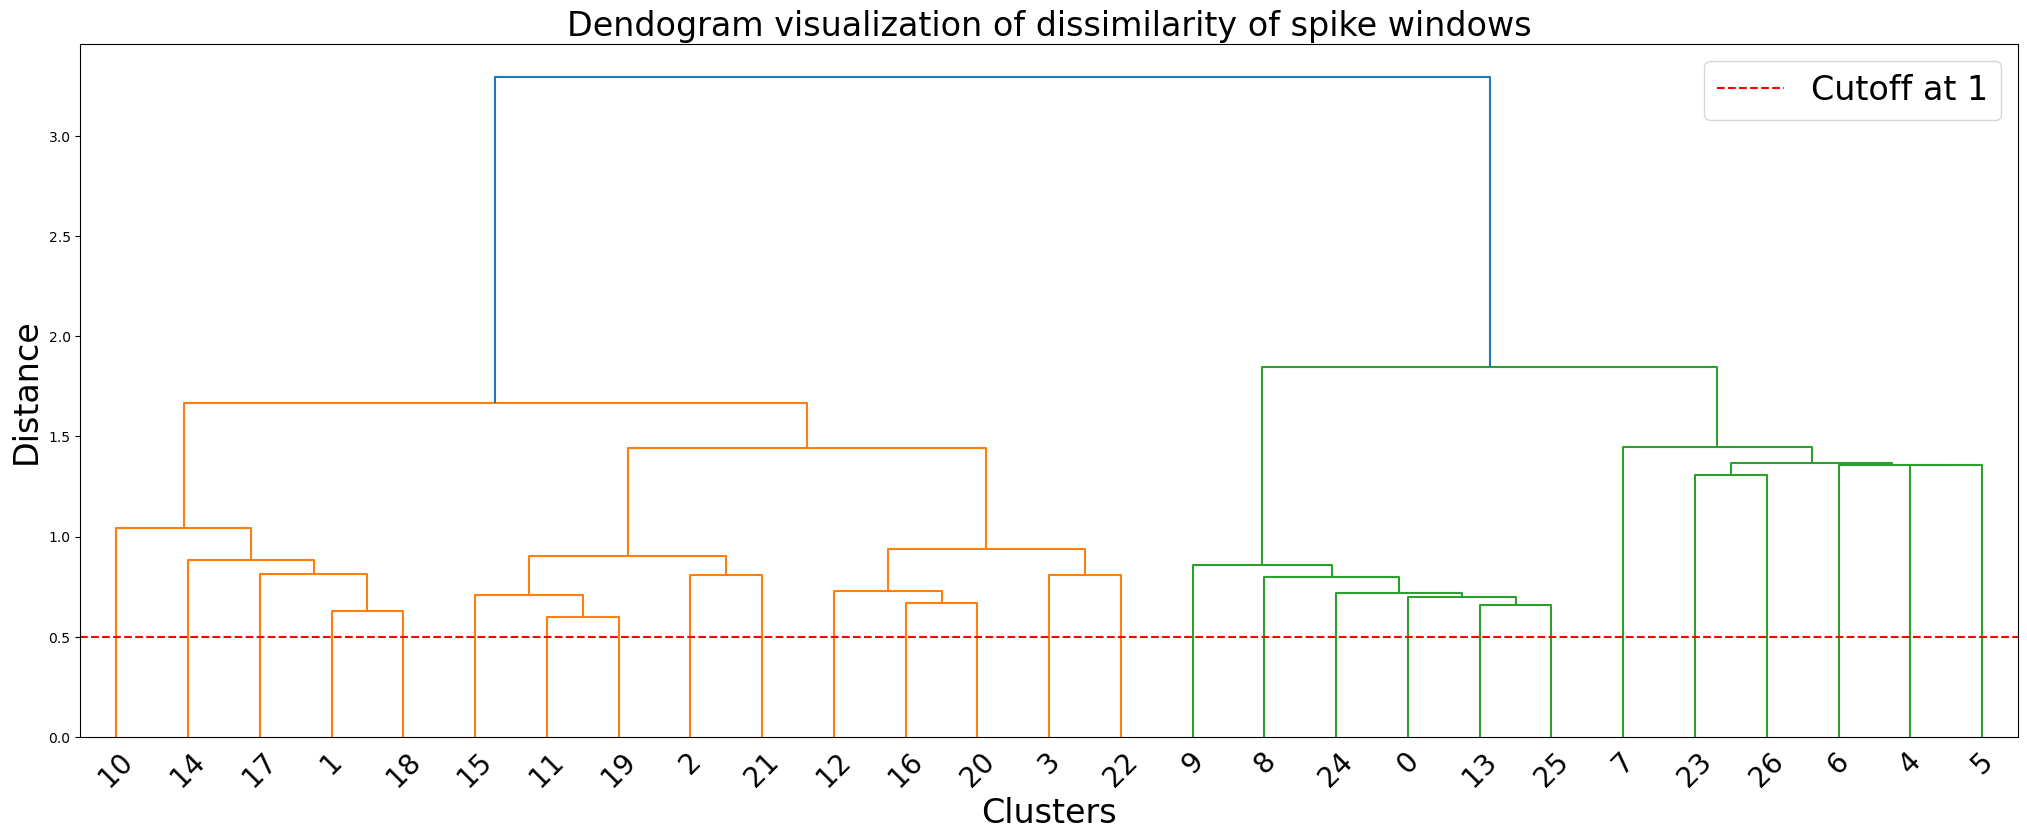

In [269]:
fig = plt.figure(figsize=(25, 9))
HDP = linkage(dissimy, method='complete')
dn = dendrogram(HDP)

# Add a horizontal line at the cutoff value of 1
plt.axhline(y=0.5, color='r', linestyle='--', label='Cutoff at 1')

# Add labels and legend
plt.title("Dendogram visualization of dissimilarity of spike windows", fontsize=24)
plt.ylabel('Distance', fontsize=24)
plt.xlabel('Clusters', fontsize=24)
plt.tick_params(axis='x', labelsize=20)
plt.legend(fontsize=24)
plt.show()

In [270]:
clusters[N_labels==5]

array([], dtype=int64)

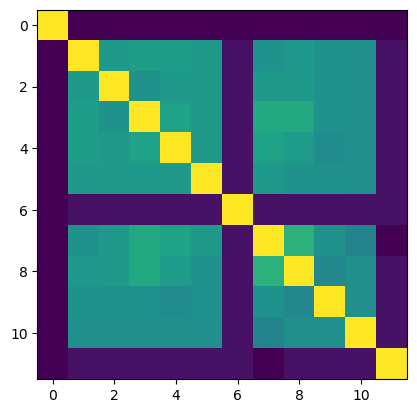

In [271]:
plt.figure()
plt.imshow(dissimilarity)

## Clustering 2 sparse

In [167]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
    str_temp = str(temp)
    time_differences.append(temp)
    if str_temp in cluster_sq.keys():
        cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
    else:
        cluster_sq[str_temp] = [cluster]
''' 
This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 


with some help from chatgpt
'''
from collections import Counter

# Convert the list of lists to a set of tuples to remove duplicates
unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

# Convert the set of tuples back to a list of lists
unique_sublists = [list(sublist) for sublist in unique_sublists_set]

# Count the occurrences of each unique sublist in the original list
sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

# Print the unique sublists and their respective counts
for sublist in unique_sublists:
    count = sublist_counts[tuple(sublist)]
    print(f"{sublist}: {count} occurrences")

sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron

''' to visualize the clusters'''

recovered_labels = np.zeros_like(clusters)
for l, key in enumerate(sublist_keys_filt):
    for k in cluster_sq[str(key)]:
        recovered_labels[clusters == k] = l+1

''' to get the timings'''

# Sort y according to x
sorted_indices = np.argsort(T_labels)
sorted_x = T_labels[sorted_indices]

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)
    
    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)



[47, 47, 5, 122, 23, 15]: 3 occurrences
[476, 96]: 1 occurrences
[47, 47, 5, 122, 4, 19, 15]: 4 occurrences
[795]: 1 occurrences
[94, 5, 122, 4, 19]: 1 occurrences
[204, 177, 155, 6]: 1 occurrences
[496]: 1 occurrences
[801]: 3 occurrences
[47, 52, 122, 4, 19, 15]: 1 occurrences
[413, 26, 488]: 1 occurrences
[413, 26, 484, 4]: 10 occurrences
[463, 332, 6]: 3 occurrences
[163]: 1 occurrences
[413, 26, 451, 33, 4]: 2 occurrences
[19, 396]: 1 occurrences
[678, 123]: 1 occurrences
[413]: 1 occurrences
[40, 94, 5, 122, 4, 19, 15]: 1 occurrences
[47, 52, 24, 98, 4, 19, 15, 22]: 2 occurrences
[10]: 1 occurrences
[47, 47, 5, 122, 4, 19]: 1 occurrences
[463, 177, 155, 6, 152]: 1 occurrences
[413, 26, 57, 427, 4]: 11 occurrences
[457, 177, 155]: 1 occurrences
[413, 26, 57, 427]: 1 occurrences
[463, 177, 155, 6]: 10 occurrences
[795, 6]: 2 occurrences
[47, 47, 5, 24, 98, 4, 19, 15, 22]: 3 occurrences
[47, 47, 5, 126, 19, 15]: 1 occurrences
[177]: 1 occurrences
[640, 155, 6]: 10 occurrences
[396, 

In [168]:
pattern_template = []
patterns = []
for i in range(len(all_times)):
    pattern = []
    pattern_template.append([])
    for time in all_times[i]:
        condition = (T_labels > time-window_dim*2) & (T_labels < time + window_dim*2)
        pattern = [tuple(k) for k in np.array([T_labels[condition]-time, N_labels[condition]]).T] # creating a list of tuples
        pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
        patterns.append(pattern)


Lets visualize the overlapping instnaces of the pattern

In [166]:
for i,pattern in enumerate(pattern_template):
    counts = [pattern.count(k) for k in pattern]
    pattern_template[i] = np.array(pattern)[np.where(counts == np.max(counts))[0]]
    pattern_template[i][:,0] -= min(pattern_template[i][:,0])
    pattern_template[i] = np.unique(pattern_template[i],axis=0)
    

In [167]:
win_size = (N,1+max([max(k[:,0]) for k in pattern_template]))
pattern_img = np.zeros((len(pattern_template),*win_size))
for p,pattern in enumerate(pattern_template):
    for (i,j) in pattern:
        pattern_img[p,j,i] = 1
    

ValueError: max() arg is an empty sequence

We are left with pattern template candidates. There could be several copies of the same pattern template. 
There could be overlapping pattern templates that vary by n pixels. There could even be more patterns than initialized if
a noisy spike occurs at just the right time.
One approach (and the one that so far results in the best performance) is to correlate each pattern and re-cluster the templates.




In [155]:
from scipy.signal import correlate

matrix_x = pattern_img
matrix_y = pattern_img

# Calculate cross-correlation matrix
cross_corr_matrix = np.zeros((matrix_x.shape[0], matrix_y.shape[0]))

for x_channel_idx in range(matrix_x.shape[0]):
    for y_channel_idx in range(matrix_x.shape[0]):
        cross_corr = correlate(matrix_x[x_channel_idx,...], matrix_x[y_channel_idx,...], mode='full')
        max_corr = np.max(cross_corr)/ np.sum(matrix_x[x_channel_idx])
        cross_corr_matrix[x_channel_idx, y_channel_idx] = max_corr

dissimilarity = cross_corr_matrix-1

In [134]:
dissimilarity.shape[0]

7

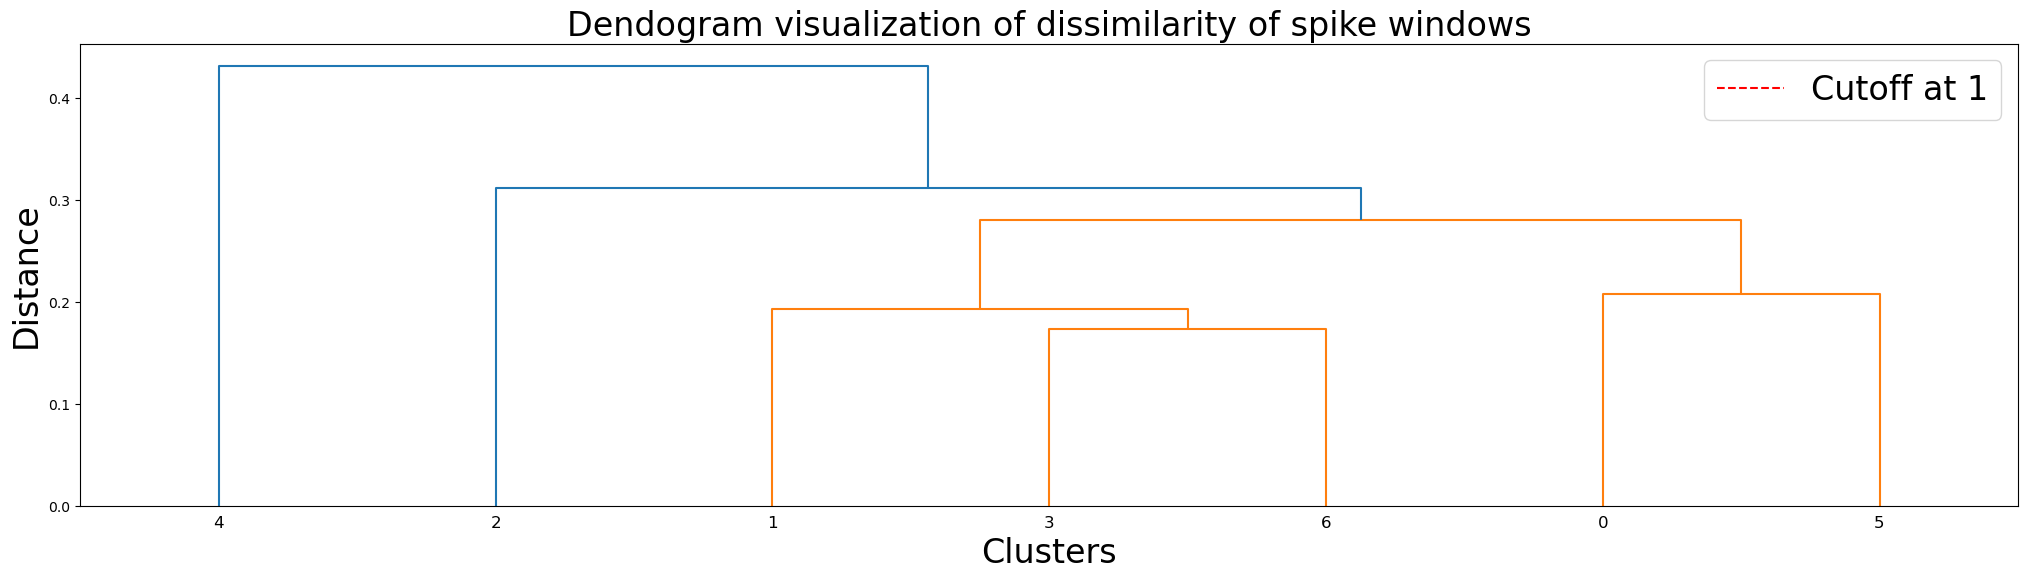

In [135]:
if dissimilarity.shape[0] >1:
    # Create the dendrogram plot
    fig = plt.figure(figsize=(25, 6))
    HDP = linkage(dissimilarity, method='complete')
    dn = dendrogram(HDP)

    # Add a horizontal line at the cutoff value of 1
    plt.axhline(y=1, color='r', linestyle='--', label='Cutoff at 1')

    # Add labels and legend
    plt.title("Dendogram visualization of dissimilarity of spike windows", fontsize=24)
    plt.ylabel('Distance', fontsize=24)
    plt.xlabel('Clusters', fontsize=24)
    plt.legend(fontsize=24)

    plt.show()

In [136]:
raster_size = (N,max(T_labels)+1)
raster = np.zeros((raster_size))
for (i,j) in zip(T_labels,N_labels):
    raster[j,i] =1
    

In [137]:
if dissimilarity.shape[0] >1:
    method1_labels = fcluster(HDP,cutoff, criterion='distance')
else:
    method1_labels = [1]

pattern_convolutions = np.zeros((pattern_img.shape[0], raster.shape[1]+pattern_img.shape[2]-1))
for j in range(pattern_img.shape[0]):
    for i in range(pattern_img.shape[1]):
        pattern_convolutions[j] += correlate(raster[i,:], pattern_img[j,i,:], mode='full')
    pattern_convolutions[j] /= np.sum(pattern_img[j,:,:]) # normalize the convolution
    
detected_patterns = pattern_convolutions.copy()
detected_patterns[detected_patterns != 1] = 0
detected_patterns = np.sum(detected_patterns,axis=1)

method1_pattern_winners = []
for l in np.unique(method1_labels):
    idc = np.where(method1_labels==l)[0]
    temp = detected_patterns[method1_labels==l]
    method1_pattern_winners.append(idc[temp == max(temp)][0])
    
method1_pattern_template = pattern_img[method1_pattern_winners]
method1_pattern_template.shape

print('Method 1 detected patterns:', method1_pattern_winners)

Method 1 detected patterns: [0]


Once the patterns are clustered, a pattern "winner" from each cluster is chosen based on how many patterns it detects. Pattern templates that detect more patterns are assumed to be "better" than it's competitors within the same clsuter labe. 
method1_pattern_winners shows the indices of the patterns winners that emerge.

[]

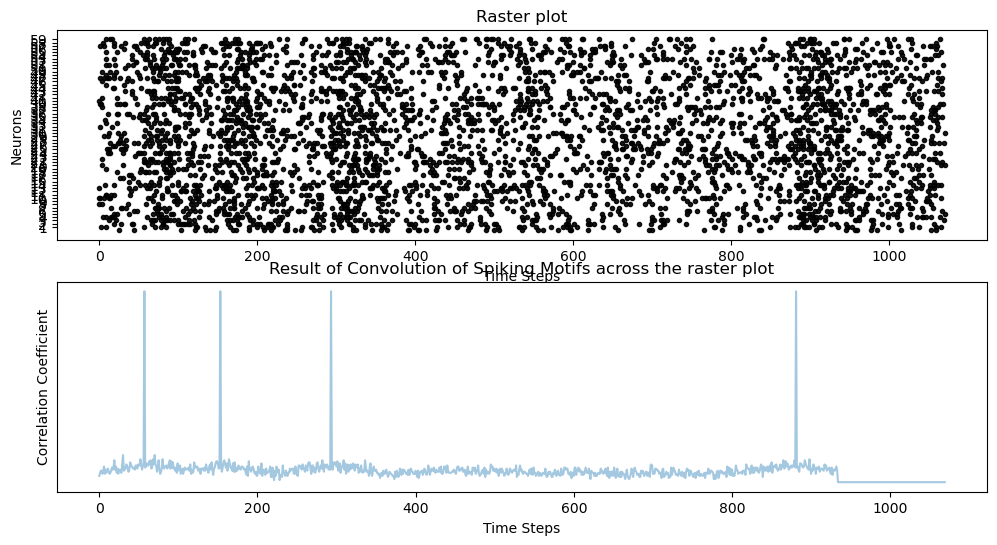

In [138]:
fig,ax = plt.subplot_mosaic('F;G',figsize=(12,6))


# Scatter plot for F
ax['F'].scatter(T_labels, N_labels, alpha=0.9, c='black', marker='.');
ax['F'].set_title('Raster plot');
ax['F'].set_xlabel('Time Steps');
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons


T=max(T_labels)
M = len(method1_pattern_winners)
D = method1_pattern_template.shape[2]

sanity_check = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        if raster[:,i:i+D].shape[1] == D:
            sanity_check[i,j] = np.sum(method1_pattern_template[j,...]*raster[:,i:i+D])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])
    

# Plot for G
[ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

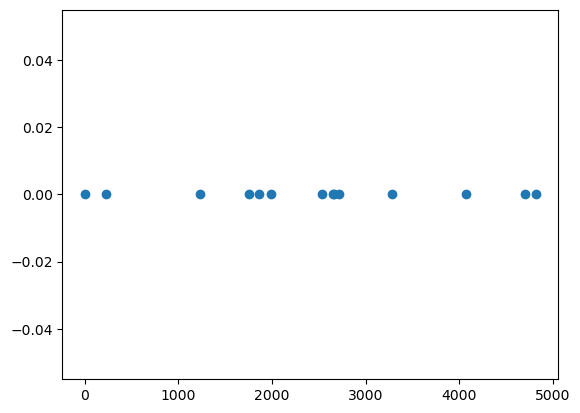

In [93]:
plt.figure()
plt.scatter(np.where(sanity_check>=0.75)[0],np.where(sanity_check>=0.75)[1])
plt.show()

In [96]:
method1_pattern_template.shape

(1, 60, 143)

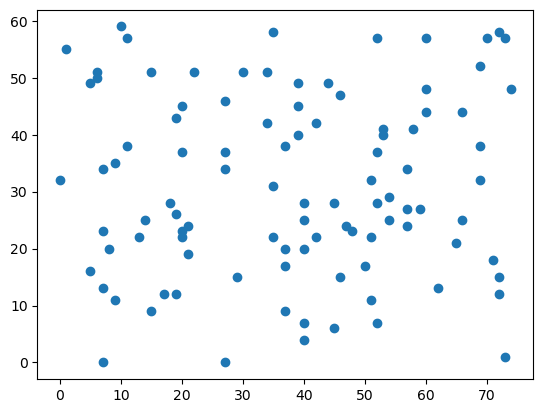

In [97]:
plt.figure()
plt.scatter(np.where(method1_pattern_template[0])[1],np.where(method1_pattern_template[0])[0])


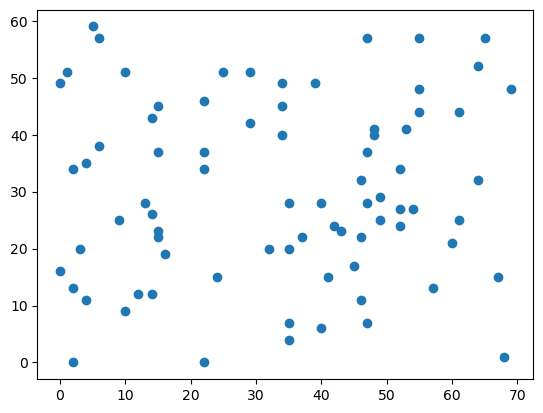

In [105]:
plt.figure()
plt.scatter(K_sparse[1],K_sparse[0])


## Performance - Comparing Detected STM's

In [815]:
def get_acc(matrix_x,matrix_y):
    from scipy.signal import correlate
    # Calculate cross-correlation matrix
    cross_corr_matrix = np.zeros((matrix_x.shape[2], matrix_y.shape[2]))

    for x_channel_idx in range(matrix_x.shape[2]):
        for y_channel_idx in range(matrix_y.shape[2]):
            cross_corr = np.zeros((matrix_x.shape[1]+matrix_y.shape[1]-1))
            for n in range(matrix_x.shape[0]):
                cross_corr += correlate(matrix_x[n, :, x_channel_idx], matrix_y[n, :, y_channel_idx], mode='full')
            max_corr = np.max(cross_corr) / max(np.sum(matrix_x[...,x_channel_idx]),np.sum(matrix_y[...,y_channel_idx]))
            cross_corr_matrix[x_channel_idx, y_channel_idx] = max_corr
#     print(cross_corr_matrix)
#     print( np.sum(matrix_x[...,x_channel_idx]))
    SM_acc_m1 = np.max(cross_corr_matrix,axis=1)
    return SM_acc_m1, cross_corr_matrix

In [816]:
matrix_x = K_dense
matrix_y = method1_pattern_template
matrix_y = np.transpose(matrix_y,[1,2,0])

SM_acc_m1, cc_1 = get_acc(matrix_x,matrix_y)

In [817]:
SM_acc_m1, cc_1

(array([1.        , 0.44444444, 0.90909091, 0.88888889]),
 array([[1.        , 0.08333333, 0.16666667, 0.08333333, 0.25      ,
         0.16666667],
        [0.16666667, 0.09090909, 0.11111111, 0.44444444, 0.22222222,
         0.11111111],
        [0.08333333, 0.90909091, 0.1       , 0.2       , 0.1       ,
         0.1       ],
        [0.25      , 0.09090909, 0.125     , 0.25      , 0.88888889,
         0.125     ]]))

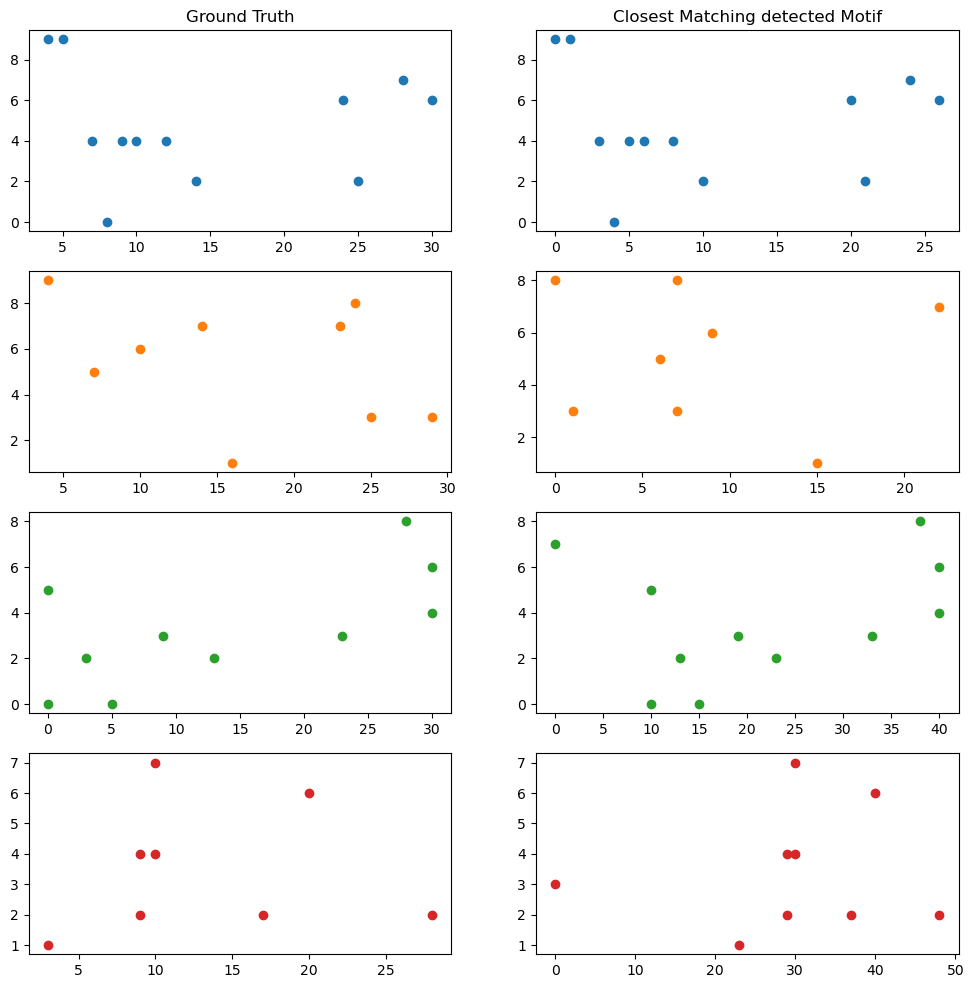

In [818]:
motif_map = (np.arange(0,M),np.argmax(cc_1,axis=1))
motif_map
fig,ax = plt.subplots(len(motif_map[0]),len(motif_map),figsize=(12,M*3))
for i,(a,b) in enumerate(zip(motif_map[0],motif_map[1])):
    ax[i,0].scatter(np.where(K_dense[...,a])[1],np.where(K_dense[...,a])[0],c=palette[i+1])
    ax[i,1].scatter(np.where(method1_pattern_template[b])[1],np.where(method1_pattern_template[b])[0],c=palette[i+1])

ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Closest Matching detected Motif')
plt.show()

In [819]:
print('Method 1, average SM_accuracy: ', sum(SM_acc_m1)/M)
print('Method 1, SM_accuracy: ', SM_acc_m1)

Method 1, average SM_accuracy:  0.8106060606060606
Method 1, SM_accuracy:  [1.         0.44444444 0.90909091 0.88888889]
